In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 3090, 24576 MiB, 14488 MiB


In [2]:
%pip install pytube opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pytube import YouTube
import torch
from torchvision import transforms
import cv2
import numpy as np
import diffusers
from tqdm import tqdm
from tqdm import trange
torch.autograd.set_grad_enabled(False)

/home/brian/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Time string example: 01:50:00
def convert_time_string_to_seconds(time_str):
    time_str = time_str.split(':')
    time_str.reverse()
    time = 0
    for i in range(len(time_str)):
        time += int(time_str[i]) * (60 ** i)
    return time

def get_frames_from_mp4_file(filename, start, end, fps):
    print(f'Getting frames from {filename} between {start} and {end} (fps: {fps})')
    start_seconds = convert_time_string_to_seconds(start)
    end_seconds = convert_time_string_to_seconds(end)
    vidcap = cv2.VideoCapture(filename)
    success = True
    count = 0
    frames = []
    while success and count < end_seconds * fps:
        success,image = vidcap.read()
        if success and count >= start_seconds * fps:
            frames.append(image)
        count += 1
    return frames

def transform_frames(frames):
    new_frames = []
    image_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
    ])
    for frame in tqdm(frames, desc="Transforming frames"):
        frame = torch.tensor(frame)
        frame = frame.permute(2, 0, 1)
        frame = frame[[2, 0, 1], :, :]
        frame = image_transform(frame)
        new_frames.append(frame)
    return new_frames

def download_youtube_video(url):
    yt = YouTube(url)
    mp4_files = yt.streams.filter(file_extension="mp4")
    stream = mp4_files.get_by_resolution("720p")
    file_name = stream.default_filename
    fps = stream.fps
    if file_name in os.listdir("./output"):
        print(f'File {file_name} already downloaded')
    else:
        stream.download("./output")
    print(f'FPS: {fps}')
    return file_name, fps

# write mp4 file from frames
def write_mp4_from_frames(frames, fps, filename):
    height, width, layers = frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
    for i in trange(len(frames), desc="Writing frames to video file"):
        out.write(frames[i])
    out.release()

def transform_to_opencv_frame(frame):
    frame = torch.Tensor(frame)
    frame *= 256
    frame = torch.clamp(frame, 0, 255)
    frame = frame[[1, 2, 0], :, :]
    frame = frame.permute(1, 2, 0)
    frame = frame.numpy()
    frame = frame.astype(np.uint8)
    return frame

def encode_then_decode_frames(frames, vae):
    new_frames = []
    for frame in tqdm(frames, desc="Encoding frames with VAE"):
        frame = frame.to("cuda")
        frame = frame[None,:,:,:]
        encoded = encode_latents(vae, frame)
        decoded = decode_latents(vae, encoded)
        del encoded
        new_frames.append(decoded)
        frame = frame.to("cpu")
    return new_frames

def decode_latents(vae, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    numpyimg = torch.tensor(image.to("cpu").detach().numpy()[0])
    del image
    return numpyimg

def encode_latents(vae, image):
    latent_dist = vae.encode(image).latent_dist
    latents = latent_dist.sample()
    latents = 0.18215 * latents
    return latents

def get_frames_from_videos(videos):
    frames = []
    fps = 0
    for video in videos:
        url, start_time, end_time = video
        file_name, fps = download_youtube_video(url)
        frames += get_frames_from_mp4_file(f"./output/{file_name}", start_time, end_time, fps)
    return frames, fps

In [5]:
# Get a VAE from the StableDiffusionPipeline
vae = diffusers.AutoencoderKL.from_pretrained("/workspace/models/stable-diffusion-2-depth/vae", strict=False)
vae = vae.to("cuda")

In [6]:
# Get frames from video
frames, fps = get_frames_from_videos([ \
    ["https://www.youtube.com/watch?v=J2UwI6FDs-k", "00:00", "00:05"], \
    ["https://www.youtube.com/watch?v=izt6xgtP-X8", "00:00", "00:03"], \
    ["https://www.youtube.com/watch?v=nxYkBfc4Iys", "03:37", "03:51"], \
    ["https://www.youtube.com/watch?v=8JrLNQIVBj4", "00:00", "0:10"], \
])
print(f'Got {len(frames)} frames')
unencoded_tensor_frames = transform_frames(frames)

FPS: 24
Getting frames from ./output/Salesforce Mobile App Demo.mp4 between 00:00 and 00:05 (fps: 24)
File Book-flipping-pages.mp4 already downloaded
FPS: 30
Getting frames from ./output/Book-flipping-pages.mp4 between 00:00 and 00:03 (fps: 30)
File GoPro on an Arrow!.mp4 already downloaded
FPS: 30
Getting frames from ./output/GoPro on an Arrow!.mp4 between 03:37 and 03:51 (fps: 30)
File Learning to Ride a Bike.mp4 already downloaded
FPS: 30
Getting frames from ./output/Learning to Ride a Bike.mp4 between 00:00 and 0:10 (fps: 30)
Got 921 frames


Transforming frames: 100%|██████████| 921/921 [00:13<00:00, 66.47it/s]


In [7]:
encoded_tensor_frames = encode_then_decode_frames(unencoded_tensor_frames, vae)

Encoding frames with VAE: 100%|██████████| 921/921 [02:52<00:00,  5.34it/s]


torch.Size([3, 512, 512])

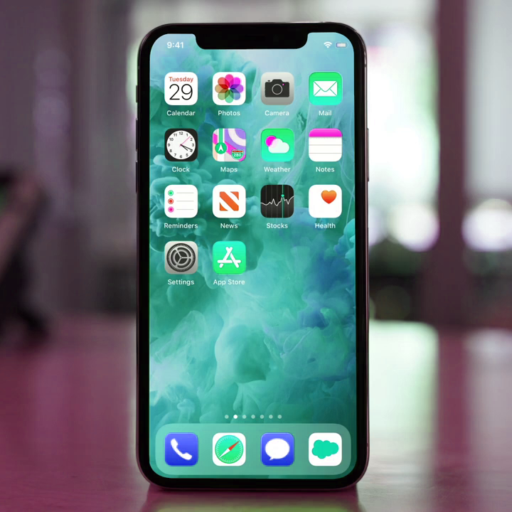

torch.Size([3, 512, 512])


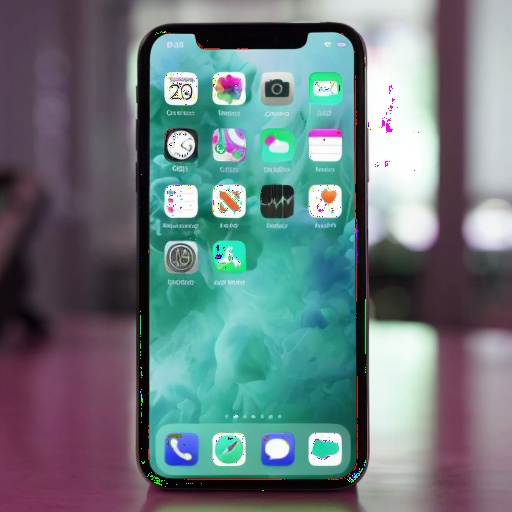

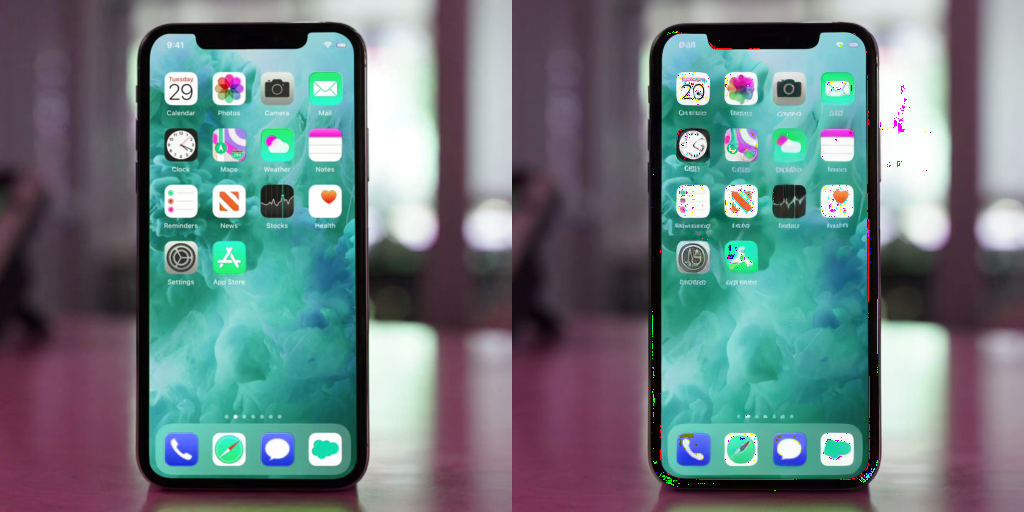

In [8]:
# stack a frame
frame_1 = unencoded_tensor_frames[0]
display(frame_1.shape)
display(transforms.ToPILImage()(frame_1))
frame_2 = encoded_tensor_frames[0]
print(frame_2.shape)
display(transforms.ToPILImage()(frame_2))
stacked = torch.cat((frame_1, frame_2), 2)
display(transforms.ToPILImage()(stacked))

In [9]:
opencv_frames = []
for i in range(len(unencoded_tensor_frames)):
    frame_1 = unencoded_tensor_frames[i]
    frame_2 = encoded_tensor_frames[i]
    stacked = torch.cat((frame_1, frame_2), 2)
    opencv_frames.append(transform_to_opencv_frame(stacked))



NameError: name 'file_name' is not defined

In [10]:
write_mp4_from_frames(opencv_frames, fps, f'./output/output.avi')

Writing frames to video file: 100%|██████████| 921/921 [00:03<00:00, 235.01it/s]
